1. Pre-processing

In [3]:
from project.data_extraction.dummy_data_extractor import extract_dummy_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

master_table = extract_dummy_data(r"C:\Users\ccarandang\OneDrive - Enova Facilities Management\Documents\GitHub\HubgradeDataCleaning\HubgradeDataCleaning\project\dummy_data")
master_table = master_table.at[0,"his"]
df = master_table.dropna()

In [4]:
X_full = df.iloc[:,2:].to_numpy()
X_full

array([[ 0.        ],
       [ 4.10196114],
       [24.86417007],
       ...,
       [35.32480621],
       [33.50623703],
       [33.50623703]])

In [5]:
y = df.iloc[:,2:]
y

,DMC Building 1 Data Quality Tests New-Point
1215,0.000000
1216,4.101961
1217,24.864170
1218,28.627068
1219,32.381767
...,...
4391,31.959213
4392,33.179718
4393,35.324806
4394,33.506237


In [6]:
N_SPLITS = 5

X_full = df.iloc[:,2:].to_numpy()
y = df.iloc[:,1:-1].to_numpy()              # First column after the timestamp will be y
y_full = np.ravel(y)                        #Flatten
n_samples, n_features = X_full.shape

In [7]:
# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_root_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

In [8]:
#Table with NaN in all rows
df_nan = master_table.loc[~master_table.index.isin(master_table.dropna().index)]
df_nan

,ts,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point
0,2023-02-24 18:45:00+04:00,24.420517,NaN
1,2023-02-24 18:50:00+04:00,24.420517,NaN
2,2023-02-24 18:55:00+04:00,24.420517,NaN
3,2023-02-24 19:00:00+04:00,24.345844,NaN
4,2023-02-24 19:05:00+04:00,24.271170,NaN
...,...,...,...
1210,2023-02-28 23:35:00+04:00,23.208195,NaN
1211,2023-02-28 23:40:00+04:00,23.208195,NaN
1212,2023-02-28 23:45:00+04:00,23.208195,NaN
1213,2023-02-28 23:50:00+04:00,23.208195,NaN


In [9]:
X_missing = master_table.iloc[:,2:].to_numpy()
y_nan = master_table.iloc[:,1:-1].to_numpy()             
y_missing = np.ravel(y_nan)                        


In [10]:
# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_root_mean_squared_error", cv=N_SPLITS
    )

In [11]:
# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)
    ),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()

In [12]:
# iterative imputer is sensible to the tolerance and
# dependent on the estimator used internally.
# we tuned the tolerance to keep this example run with limited computational
# resources while not changing the results too much compared to keeping the
# stricter default value for the tolerance parameter.
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        br_estimator,
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_root_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)
scores

Original SimpleImputer           IterativeImputer                        \
  Full Data          mean    median    BayesianRidge RandomForestRegressor   
0 -0.481037     -0.774248 -0.785173        -0.774248             -0.774248   
1 -0.836395     -0.542699 -0.549422        -0.542699             -0.542699   
2 -0.656494     -0.929806 -0.941964        -0.929806             -0.929806   
3 -0.595816     -0.580864 -0.575631        -0.580864             -0.580864   
4 -1.032087     -0.795379 -0.800561        -0.795379             -0.795379   

                                 
   Pipeline KNeighborsRegressor  
0 -0.774248           -0.774248  
1 -0.542699           -0.542699  
2 -0.929806           -0.929806  
3 -0.580864           -0.580864  
4 -0.795379           -0.795379

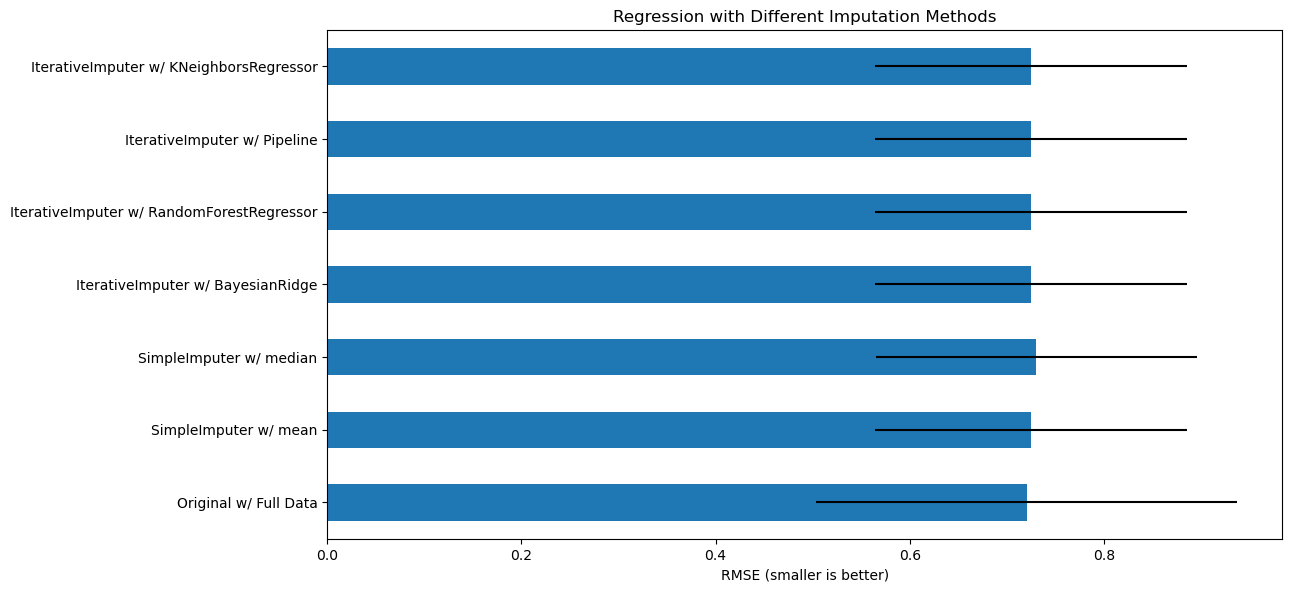

In [13]:
# plot results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("Regression with Different Imputation Methods")
ax.set_xlabel("RMSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

In [14]:
master_table
mt = master_table.set_index(["ts"])
mt

,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point
ts,,
2023-02-24 18:45:00+04:00,24.420517,NaN
2023-02-24 18:50:00+04:00,24.420517,NaN
2023-02-24 18:55:00+04:00,24.420517,NaN
2023-02-24 19:00:00+04:00,24.345844,NaN
2023-02-24 19:05:00+04:00,24.271170,NaN
...,...,...
2023-03-12 00:40:00+04:00,24.119339,31.959213
2023-03-12 00:45:00+04:00,24.119339,33.179718
2023-03-12 00:50:00+04:00,24.119339,35.324806


In [15]:
mt["status"] = mt.isna().any(axis=1)#.replace(True,1).replace(False,0)
mt

,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point,status
ts,,,
2023-02-24 18:45:00+04:00,24.420517,NaN,True
2023-02-24 18:50:00+04:00,24.420517,NaN,True
2023-02-24 18:55:00+04:00,24.420517,NaN,True
2023-02-24 19:00:00+04:00,24.345844,NaN,True
2023-02-24 19:05:00+04:00,24.271170,NaN,True
...,...,...,...
2023-03-12 00:40:00+04:00,24.119339,31.959213,False
2023-03-12 00:45:00+04:00,24.119339,33.179718,False
2023-03-12 00:50:00+04:00,24.119339,35.324806,False


In [16]:
imputer = IterativeImputer()
imputed = imputer.fit_transform(mt)
mt_imputed = pd.DataFrame(imputed, index=mt.index, columns=mt.columns)
mt_imputed

,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point,status
ts,,,
2023-02-24 18:45:00+04:00,24.420517,40.016682,1.0
2023-02-24 18:50:00+04:00,24.420517,40.016682,1.0
2023-02-24 18:55:00+04:00,24.420517,40.016682,1.0
2023-02-24 19:00:00+04:00,24.345844,39.763552,1.0
2023-02-24 19:05:00+04:00,24.271170,39.510415,1.0
...,...,...,...
2023-03-12 00:40:00+04:00,24.119339,31.959213,0.0
2023-03-12 00:45:00+04:00,24.119339,33.179718,0.0
2023-03-12 00:50:00+04:00,24.119339,35.324806,0.0


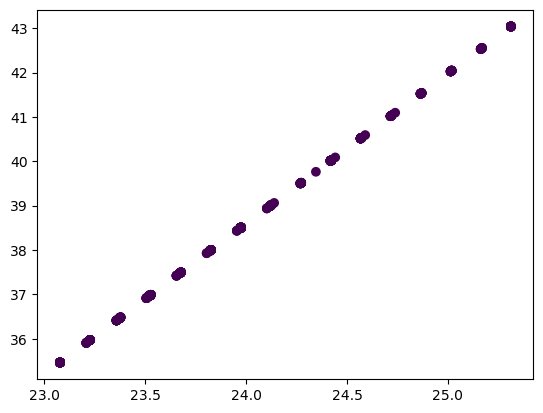

In [17]:
mt_predict = mt_imputed[mt_imputed["status"]==1]
mt_predict_y = mt_predict.iloc[:,1:-1]
mt_predict_X = mt_predict.iloc[:,0:1]
plt.scatter(mt_predict_X, mt_predict_y, c=mt_predict.status, label="data")

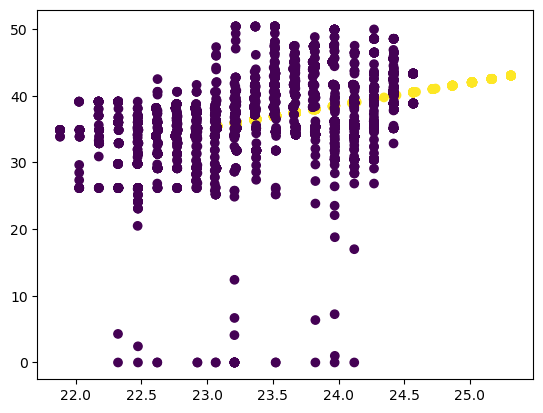

In [18]:
import seaborn as sns

mt_y = mt_imputed.iloc[:,1:-1]
mt_X = mt_imputed.iloc[:,0:1]

plt.scatter(mt_X, mt_y, c=mt_imputed.status, label="data")

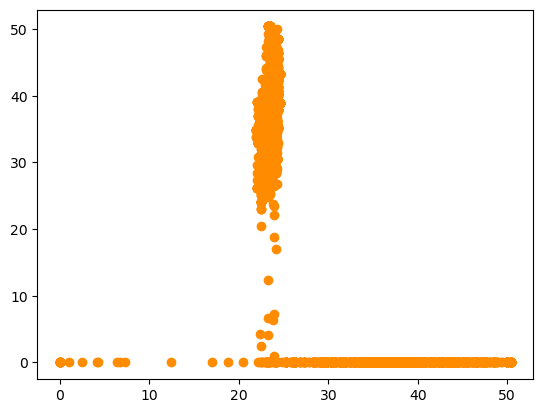

In [19]:
y = mt.iloc[:,1:]
X = mt.iloc[:,0:-1]
plt.scatter(X, y, color="darkorange", label="data")


In [20]:
imputer = IterativeImputer()
imputed = imputer.fit_transform(mt)
mt_imputed = pd.DataFrame(imputed, index=mt.index, columns=mt.columns)
mt_imputed

,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point,status
ts,,,
2023-02-24 18:45:00+04:00,24.420517,40.016682,1.0
2023-02-24 18:50:00+04:00,24.420517,40.016682,1.0
2023-02-24 18:55:00+04:00,24.420517,40.016682,1.0
2023-02-24 19:00:00+04:00,24.345844,39.763552,1.0
2023-02-24 19:05:00+04:00,24.271170,39.510415,1.0
...,...,...,...
2023-03-12 00:40:00+04:00,24.119339,31.959213,0.0
2023-03-12 00:45:00+04:00,24.119339,33.179718,0.0
2023-03-12 00:50:00+04:00,24.119339,35.324806,0.0


In [21]:
df_nan = master_table.loc[~master_table.index.isin(master_table.dropna().index)]
df_nan = df_nan.set_index(["ts"])
df_nan

,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point
ts,,
2023-02-24 18:45:00+04:00,24.420517,NaN
2023-02-24 18:50:00+04:00,24.420517,NaN
2023-02-24 18:55:00+04:00,24.420517,NaN
2023-02-24 19:00:00+04:00,24.345844,NaN
2023-02-24 19:05:00+04:00,24.271170,NaN
...,...,...
2023-02-28 23:35:00+04:00,23.208195,NaN
2023-02-28 23:40:00+04:00,23.208195,NaN
2023-02-28 23:45:00+04:00,23.208195,NaN


2. Nearest Neighbors Regression

In [22]:
from project.data_extraction.dummy_data_extractor import extract_dummy_data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

master_table = extract_dummy_data(r"C:\Users\ccarandang\OneDrive - Enova Facilities Management\Documents\GitHub\HubgradeDataCleaning\HubgradeDataCleaning\project\dummy_data")


master_table = master_table.at[0,"his"]
mt = master_table.set_index(["ts"])

# Tag and filter rows with missing
mt["status"] = mt.isna().any(axis=1)
mt_predict = mt[mt["status"]==1]
X_predict = mt_predict.iloc[:,0:1] 

# Filtered master table
mt_train = mt.dropna()
mt_train

# Load the dataset
# X = mt.iloc[:,1:-1]  Enable for SS
# y = mt.iloc[:,0:1]   Enable for SS

y = mt_train.iloc[:,1:-1]    #Custom due to sample dataset
X = mt_train.iloc[:,0:1]     #Custom due to sample dataset

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# # Apply KNN regression
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)
predictions = knn_regressor.predict(X_test)
predictions
# Evaluate the model
print('Score:', knn_regressor.score(X_test, y_test))

predict = knn_regressor.predict(X_predict)
df = pd.DataFrame(data=predict, index=X_predict.index, columns=['y_pred'])
df

Score: 0.6777813214277945


,y_pred
ts,
2023-02-24 18:45:00+04:00,48.554485
2023-02-24 18:50:00+04:00,48.554485
2023-02-24 18:55:00+04:00,48.554485
2023-02-24 19:00:00+04:00,41.120193
2023-02-24 19:05:00+04:00,46.487816
...,...
2023-02-28 23:35:00+04:00,29.523151
2023-02-28 23:40:00+04:00,29.523151
2023-02-28 23:45:00+04:00,29.523151


In [24]:
from project.models.kNeighborsRegressor import kNeighbors_Regressor
from project.data_extraction.dummy_data_extractor import extract_dummy_data
master_table = extract_dummy_data(r"C:\Users\ccarandang\OneDrive - Enova Facilities Management\Documents\GitHub\HubgradeDataCleaning\HubgradeDataCleaning\project\dummy_data")
master_table

kNeighbors_Regressor(master_table)

Score: 0.6777813214277945


,y_pred
ts,
2023-02-24 18:45:00+04:00,48.554485
2023-02-24 18:50:00+04:00,48.554485
2023-02-24 18:55:00+04:00,48.554485
2023-02-24 19:00:00+04:00,41.120193
2023-02-24 19:05:00+04:00,46.487816
...,...
2023-02-28 23:35:00+04:00,29.523151
2023-02-28 23:40:00+04:00,29.523151
2023-02-28 23:45:00+04:00,29.523151


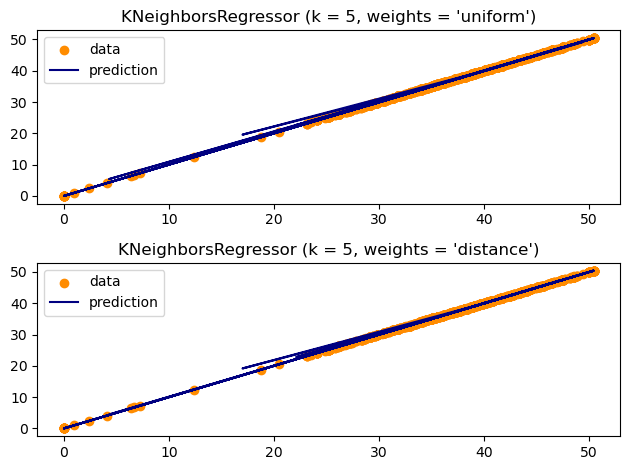

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import neighbors

X = df.iloc[:,2:]
y = df.iloc[:,2:]
 
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_neighbors = 5

for i, weights in enumerate(["uniform", "distance"]):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(X_train, y_train).predict(X_test)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X_train, y_train, color="darkorange", label="data")
    plt.plot(X_test, y_, color="navy", label="prediction")
    plt.axis("tight")
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.tight_layout()
plt.show()

Testing Iterative Imputer

In [24]:
from project.data_extraction.dummy_data_extractor import extract_dummy_data
master_table = extract_dummy_data(r"C:\Users\ccarandang\OneDrive - Enova Facilities Management\Documents\GitHub\HubgradeDataCleaning\HubgradeDataCleaning\project\dummy_data")

import pandas as pd
from sklearn.impute import IterativeImputer

def iterative_Imputation(master_table):
    """
    Input
    master_table: main table received from SS

    Output
    mt_predict: dataframe with predictions for all rows with missing columns. Index names as ts
    """
    master_table = master_table.at[0,"his"]
    mt = master_table.set_index(["ts"])
    mt["status"] = mt.isna().any(axis=1)
    imputer = IterativeImputer()
    imputed = imputer.fit_transform(mt)
    mt_imputed = pd.DataFrame(imputed, index=mt.index, columns=mt.columns)
    mt_predict = mt_imputed[mt_imputed["status"]==1].drop(["status"],axis=1)
    
    return mt_predict

iterative_Imputation(master_table)

,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point
ts,,
2023-02-24 18:45:00+04:00,24.420517,40.016682
2023-02-24 18:50:00+04:00,24.420517,40.016682
2023-02-24 18:55:00+04:00,24.420517,40.016682
2023-02-24 19:00:00+04:00,24.345844,39.763552
2023-02-24 19:05:00+04:00,24.271170,39.510415
...,...,...
2023-02-28 23:35:00+04:00,23.208195,35.907077
2023-02-28 23:40:00+04:00,23.208195,35.907077
2023-02-28 23:45:00+04:00,23.208195,35.907077


In [25]:
from project.models.iterativeImputation import iterative_Imputation
from project.data_extraction.dummy_data_extractor import extract_dummy_data
master_table = extract_dummy_data(r"C:\Users\ccarandang\OneDrive - Enova Facilities Management\Documents\GitHub\HubgradeDataCleaning\HubgradeDataCleaning\project\dummy_data")

iterative_Imputation(master_table)

,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point
ts,,
2023-02-24 18:45:00+04:00,24.420517,40.016682
2023-02-24 18:50:00+04:00,24.420517,40.016682
2023-02-24 18:55:00+04:00,24.420517,40.016682
2023-02-24 19:00:00+04:00,24.345844,39.763552
2023-02-24 19:05:00+04:00,24.271170,39.510415
...,...,...
2023-02-28 23:35:00+04:00,23.208195,35.907077
2023-02-28 23:40:00+04:00,23.208195,35.907077
2023-02-28 23:45:00+04:00,23.208195,35.907077


RandomForestRegressor

In [5]:
from project.data_extraction.dummy_data_extractor import extract_dummy_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

master_table = extract_dummy_data(r"C:\Users\ccarandang\OneDrive - Enova Facilities Management\Documents\GitHub\HubgradeDataCleaning\HubgradeDataCleaning\project\dummy_data")


master_table = master_table.at[0,"his"]
mt = master_table.set_index(["ts"])

# Tag and filter rows with missing
mt["status"] = mt.isna().any(axis=1)
mt_predict = mt[mt["status"]==1]
X_predict = mt_predict.iloc[:,0:1] 

# Filtered master table
mt_train = mt.dropna()
mt_train

# Load the dataset
# X = mt.iloc[:,1:-1]  Enable for SS
# y = mt.iloc[:,0:1]   Enable for SS

y = mt_train.iloc[:,1:-1]    #Custom due to sample dataset
X = mt_train.iloc[:,0:1]     #Custom due to sample dataset

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Check for and handle categorical variables
# label_encoder = LabelEncoder()
# x_categorical = mt_train.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
# x_numerical = mt_train.select_dtypes(exclude=['object']).values
# x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
regressor.fit(X_train, y_train)
 
# Access the OOB Score
# oob_score = regressor.oob_score_
# print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions_test = regressor.predict(X_test)
 
# Evaluating the model
mse = mean_squared_error(y_test, predictions_test)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, predictions_test)
print(f'R-squared: {r2}')

predict = regressor.predict(X_predict)
df = pd.DataFrame(data=predict, index=X_predict.index, columns=['y_pred'])
df

Mean Squared Error: 9.50489477405263
R-squared: 0.749497896264316


c:\Users\ccarandang\AppData\Local\anaconda3\envs\ssv1\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ccarandang\AppData\Local\anaconda3\envs\ssv1\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


,y_pred
ts,
2023-02-24 18:45:00+04:00,48.554485
2023-02-24 18:50:00+04:00,48.554485
2023-02-24 18:55:00+04:00,48.554485
2023-02-24 19:00:00+04:00,42.600157
2023-02-24 19:05:00+04:00,46.487816
...,...
2023-02-28 23:35:00+04:00,23.840693
2023-02-28 23:40:00+04:00,23.840693
2023-02-28 23:45:00+04:00,23.840693


In [6]:
from project.models.randomForestRegressor import random_Forest_Regressor
from project.data_extraction.dummy_data_extractor import extract_dummy_data
master_table = extract_dummy_data(r"C:\Users\ccarandang\OneDrive - Enova Facilities Management\Documents\GitHub\HubgradeDataCleaning\HubgradeDataCleaning\project\dummy_data")
master_table

random_Forest_Regressor(master_table)

Mean Squared Error: 9.50489477405263
R-squared: 0.749497896264316


c:\Users\ccarandang\AppData\Local\anaconda3\envs\ssv1\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ccarandang\AppData\Local\anaconda3\envs\ssv1\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


,y_pred
ts,
2023-02-24 18:45:00+04:00,48.554485
2023-02-24 18:50:00+04:00,48.554485
2023-02-24 18:55:00+04:00,48.554485
2023-02-24 19:00:00+04:00,42.600157
2023-02-24 19:05:00+04:00,46.487816
...,...
2023-02-28 23:35:00+04:00,23.840693
2023-02-28 23:40:00+04:00,23.840693
2023-02-28 23:45:00+04:00,23.840693


BayesianRidgeRegressor

In [ ]:
from project.data_extraction.dummy_data_extractor import extract_dummy_data

master_table = extract_dummy_data(r"C:\Users\ccarandang\OneDrive - Enova Facilities Management\Documents\GitHub\HubgradeDataCleaning\HubgradeDataCleaning\project\dummy_data")

master_table = master_table.at[0,"his"]
mt = master_table.set_index(["ts"])

# Tag and filter rows with missing
mt["status"] = mt.isna().any(axis=1)
mt_predict = mt[mt["status"]==1]
X_predict = mt_predict.iloc[:,0:1] 

# Filtered master table
mt_train = mt.dropna()
mt_train

# Load the dataset
# X = mt.iloc[:,1:-1]  Enable for SS
# y = mt.iloc[:,0:1]   Enable for SS

y = mt_train.iloc[:,1:-1]    #Custom due to sample dataset
X = mt_train.iloc[:,0:1]     #Custom due to sample dataset

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)